In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import copy
import holidays
import datetime as dt
from datetime import timedelta
os.getcwd()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import networkx as nx
import shap
shap.initjs()

pd.set_option('display.max_columns', 70)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read in punctuality data
punct2019_1 = pd.read_csv("./data/Punctuality_2019_part1.csv", sep = ";")
punct2019_2 = pd.read_csv("./data/Punctuality_2019_part2.csv", sep = ";")
punct2020_1 = pd.read_csv("./data/Punctuality_2020_part1.csv", sep = ";")
punct2020_2 = pd.read_csv("./data/Punctuality_2020_part2.csv", sep = ";")
punct2021_1 = pd.read_csv("./data/Punctuality_2021_part1.csv", sep = ";")
punct2021_2 = pd.read_csv("./data/Punctuality_2021_part2.csv", sep = ";")
punct2022_1 = pd.read_csv("./data/Punctuality_2022_part1.csv", sep = ";")
punct2022_2 = pd.read_csv("./data/Punctuality_2022_part2.csv", sep = ";")
punct2023 = pd.read_csv("./data/Punctuality_2023.csv", sep = ";")
all_punct = pd.concat([punct2019_1, punct2019_2, punct2020_1, punct2020_2, punct2021_1, punct2021_2, punct2022_1, punct2022_2, punct2023], axis = 0)
all_punct = all_punct[all_punct['TRAIN_ID'].notna()].reset_index()

# read in justifications data
justifs = pd.read_parquet("~/Downloads/justif_parquet")
justifs = justifs[justifs['TRAIN_ID_resp'].notna()]
justifs['p_resp'] = justifs['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)


In [4]:
justifs_red = justifs[['DEPARTURE_DT', 'TRAIN_NUMBER', 'REF_TOD_IMPACTED_TRAIN', 'justification_dt', 'JUSTIFIED_DIFFERENTIAL_DELAY', 'trno_resp', 'TRAIN_ID_resp']]
justifs_red['DEPARTURE_DT'] = pd.to_datetime(justifs_red['DEPARTURE_DT'], format='%Y/%m/%d')
justifs_red


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN    justification_dt  \
0        2019-09-26          1707                24192376 2019-09-26 09:01:51   
1        2020-01-07          9251                24786498 2020-01-07 15:50:04   
2        2019-02-25          1528                22936396 2019-02-25 07:36:39   
3        2019-03-18          2304                23057298 2019-03-18 07:28:47   
4        2019-09-05           437                24062554 2019-09-05 16:39:22   
...             ...           ...                     ...                 ...   
724219   2022-05-02           565                30224546 2022-05-02 18:04:11   
724220   2022-03-29          7362                29999779 2022-03-29 08:43:07   
724221   2022-03-29           507                30001637 2022-03-29 12:42:07   
724225   2022-04-11          3919                30084539 2022-04-11 19:32:11   
724226   2022-04-11          8999                30116339 2022-04-11 18:30:30   

        JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  TRAIN_ID_resp  
0                                  2     7574.0     24196802.0  
1                                  2     8600.0     24788833.0  
2                                  2     7054.0     22940978.0  
3                                  2     7006.0     23058491.0  
4                                  2     8801.0     24065964.0  
...                              ...        ...            ...  
724219                             2     8972.0     30222279.0  
724220                             1     2855.0     30001588.0  
724221                             1     7009.0     30000162.0  
724225                             9     8766.0     30083107.0  
724226                             1     8999.0     30083069.0  

[528948 rows x 7 columns]

In [4]:
justifs_test = justifs_red[justifs_red['DEPARTURE_DT']== '2022-06-14']
#justifs_test['trno_resp_originator'] = justifs_test['trno_resp']
#justifs_test['TRAIN_ID_resp_originator'] = justifs_test['TRAIN_ID_resp']
justifs_test

DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN    justification_dt  \
487808   2022-06-14          8013                30484667 2022-06-14 18:53:25   
491948   2022-06-14          4658                30485271 2022-06-14 08:05:14   
493568   2022-06-14          4388                30485228 2022-06-14 17:53:45   
494033   2022-06-14          9145                30484992 2022-06-14 17:27:02   
496889   2022-06-14          3657                30480450 2022-06-14 08:39:58   
...             ...           ...                     ...                 ...   
719863   2022-06-14          2207                30482943 2022-06-14 08:57:13   
720115   2022-06-14          8777                30485109 2022-06-14 18:03:52   
720458   2022-06-14          7305                30481978 2022-06-14 07:09:53   
723488   2022-06-14          4167                30484053 2022-06-14 18:00:20   
723608   2022-06-14          9838                30485016 2022-06-14 17:03:04   

        JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  TRAIN_ID_resp  
487808                             1     3039.0     30483581.0  
491948                             2     7881.0     30481969.0  
493568                             1     8782.0     30481873.0  
494033                             1     8013.0     30484667.0  
496889                             1     7012.0     30481533.0  
...                              ...        ...            ...  
719863                             2     7009.0     30481606.0  
720115                             1     8777.0     30481774.0  
720458                             1     4927.0     30481137.0  
723488                             1     8722.0     30484871.0  
723608                             1     8741.0     30484808.0  

[658 rows x 7 columns]

In [6]:
index = np.where(justifs_test['REF_TOD_IMPACTED_TRAIN'] == 30483097.0)
index = index[0]
index

array([437])

In [7]:
test_df = justifs_test.iloc[[4,98,143,251,301, 419,437]]
test_df = test_df.reset_index()
test_df['DEPARTURE_DT'] = pd.to_datetime(test_df['DEPARTURE_DT'])
test_df = test_df.sort_values(by="justification_dt",ascending= False)
test_df_graph = test_df[['TRAIN_ID_resp','REF_TOD_IMPACTED_TRAIN']]
test_df_graph

TRAIN_ID_resp  REF_TOD_IMPACTED_TRAIN
0     30481533.0                30480450
5     30483097.0                30481533
6     30481603.0                30483097
2     30481603.0                30481533
1     30483097.0                30481533
3     30483097.0                30481533
4     30480071.0                30481603

In [8]:
test_df

index DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN  \
0  496889   2022-06-14          3657                30480450   
5  635525   2022-06-14          7012                30481533   
6  641616   2022-06-14          2305                30483097   
2  550386   2022-06-14          7012                30481533   
1  538245   2022-06-14          7012                30481533   
3  583600   2022-06-14          7012                30481533   
4  598326   2022-06-14          7007                30481603   

     justification_dt  JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  TRAIN_ID_resp  
0 2022-06-14 08:39:58                             1     7012.0     30481533.0  
5 2022-06-14 08:38:21                             1     2305.0     30483097.0  
6 2022-06-14 08:38:21                             1     7007.0     30481603.0  
2 2022-06-14 08:37:25                             1     7007.0     30481603.0  
1 2022-06-14 08:36:01                             2     2305.0     30483097.0  
3 2022-06-14 08:36:01                             1     2305.0     30483097.0  
4 2022-06-14 08:28:01                             1     1929.0     30480071.0

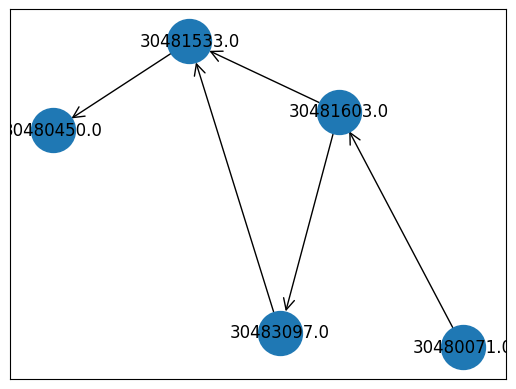

In [10]:
# create the directed graph
G = nx.DiGraph()

# add the edges
for _, row in test_df_graph.iterrows():
    if not pd.isna(row['TRAIN_ID_resp']):
        G.add_edge(str(row['TRAIN_ID_resp']), str(row['REF_TOD_IMPACTED_TRAIN']))

# draw the graph with reversed arrows
nx.draw_networkx(G, with_labels=True, arrowsize=20, node_size=1000, arrowstyle='->', edge_color='black', font_color='black')
plt.show()

In [11]:
# nodes with only incoming arrows
in_nodes = [node for node, in_degree in G.in_degree() if in_degree == 1 and G.out_degree(node) == 0]

# nodes with only outgoing arrows
out_nodes = [node for node, out_degree in G.out_degree() if out_degree >= 1 and G.in_degree(node) == 0]

# nodes with both incoming and outgoing arrows
io_nodes = [node for node in G.nodes() if G.in_degree(node) > 0 and G.out_degree(node) > 0]
print(in_nodes)
print(out_nodes)
print(io_nodes)


['30480450.0']
['30480071.0']
['30481533.0', '30483097.0', '30481603.0']


In [12]:
justifs_test

DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN    justification_dt  \
487808   2022-06-14          8013                30484667 2022-06-14 18:53:25   
491948   2022-06-14          4658                30485271 2022-06-14 08:05:14   
493568   2022-06-14          4388                30485228 2022-06-14 17:53:45   
494033   2022-06-14          9145                30484992 2022-06-14 17:27:02   
496889   2022-06-14          3657                30480450 2022-06-14 08:39:58   
...             ...           ...                     ...                 ...   
719863   2022-06-14          2207                30482943 2022-06-14 08:57:13   
720115   2022-06-14          8777                30485109 2022-06-14 18:03:52   
720458   2022-06-14          7305                30481978 2022-06-14 07:09:53   
723488   2022-06-14          4167                30484053 2022-06-14 18:00:20   
723608   2022-06-14          9838                30485016 2022-06-14 17:03:04   

        JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  TRAIN_ID_resp  
487808                             1     3039.0     30483581.0  
491948                             2     7881.0     30481969.0  
493568                             1     8782.0     30481873.0  
494033                             1     8013.0     30484667.0  
496889                             1     7012.0     30481533.0  
...                              ...        ...            ...  
719863                             2     7009.0     30481606.0  
720115                             1     8777.0     30481774.0  
720458                             1     4927.0     30481137.0  
723488                             1     8722.0     30484871.0  
723608                             1     8741.0     30484808.0  

[658 rows x 7 columns]

In [23]:
justifs_test = justifs_red[(justifs_red['justification_dt'] <= '2019-09-26 07:01:51') & (justifs_red['DEPARTURE_DT'] == '2019-09-26')]
justifs_test

DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN    justification_dt  \
7499     2019-09-26           727                24197216 2019-09-26 06:17:19   
7650     2019-09-26          2206                24194337 2019-09-26 06:56:55   
11061    2019-09-26          2206                24194337 2019-09-26 06:43:02   
20887    2019-09-26          3977                24193655 2019-09-26 06:58:39   
23212    2019-09-26          4677                24195000 2019-09-26 07:01:50   
28658    2019-09-26          7659                24197099 2019-09-26 06:54:51   
30199    2019-09-26          7010                24196355 2019-09-26 04:53:07   
41594    2019-09-26          7011                24196279 2019-09-26 06:48:17   
46554    2019-09-26          7010                24196355 2019-09-26 04:40:58   
48701    2019-09-26          7015                24196485 2019-09-26 06:56:43   
49269    2019-09-26          7302                24197336 2019-09-26 06:57:41   
49384    2019-09-26          7901                24196587 2019-09-26 06:55:39   
60545    2019-09-26          7376                24196042 2019-09-26 06:51:46   
66982    2019-09-26          7690                24197304 2019-09-26 06:32:27   
74742    2019-09-26          7792                24196327 2019-09-26 06:46:47   
80905    2019-09-26          2056                24194559 2019-09-26 07:00:27   
107913   2019-09-26          7450                24196346 2019-09-26 06:58:29   
134042   2019-09-26          7741                24196144 2019-09-26 06:58:20   
134382   2019-09-26          1503                24194462 2019-09-26 06:17:48   
135087   2019-09-26          4656                24194800 2019-09-26 06:54:58   
144097   2019-09-26          7962                24196786 2019-09-26 06:57:20   
159510   2019-09-26           529                24195193 2019-09-26 06:36:16   
161787   2019-09-26          2328                24194287 2019-09-26 06:49:22   
165345   2019-09-26          4127                24195228 2019-09-26 06:57:57   
176195   2019-09-26          7690                24197304 2019-09-26 06:31:28   
184516   2019-09-26          7496                24197916 2019-09-26 06:57:31   
194629   2019-09-26          7400                24197192 2019-09-26 06:34:34   
199344   2019-09-26          7067                24197859 2019-09-26 06:29:24   
201203   2019-09-26          7303                24197983 2019-09-26 06:00:40   
202531   2019-09-26          7687                24197914 2019-09-26 06:58:57   
212543   2019-09-26          7002                24196055 2019-09-26 06:58:56   
219926   2019-09-26          2305                24192710 2019-09-26 06:31:23   
221329   2019-09-26          7002                24196055 2019-09-26 06:51:49   
299201   2019-09-26          7450                24196346 2019-09-26 06:25:56   
306338   2019-09-26           529                24195193 2019-09-26 06:57:31   
360435   2019-09-26          7800                24196352 2019-09-26 06:02:05   

        JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  TRAIN_ID_resp  
7499                               2     7996.0     24197016.0  
7650                               2     7961.0     24196859.0  
11061                              2     7961.0     24196859.0  
20887                              2     7659.0     24197099.0  
23212                              2     7802.0     24196380.0  
28658                              2     2127.0     24192492.0  
30199                              2      553.0     24193684.0  
41594                              2      555.0     24193690.0  
46554                              2      553.0     24193684.0  
48701                              2     1556.0     24192416.0  
49269                              2     3630.0     24195583.0  
49384                              2     7952.0     24196665.0  
60545                              5     7400.0     24197192.0  
66982                              4     3805.0     24194906.0  
74742                             

## ALL DATA

In [5]:
justifs_red_sort= justifs_red.sort_values(by = "justification_dt",ascending= False)
justifs_red_sort_graph = justifs_red_sort[['TRAIN_ID_resp','REF_TOD_IMPACTED_TRAIN']]
justifs_red_sort_graph

TRAIN_ID_resp  REF_TOD_IMPACTED_TRAIN
596869     32468185.0                32463468
673897     32465562.0                32463246
516481     32464825.0                32465273
618932     32464825.0                32465273
589147     32464825.0                32465273
...               ...                     ...
193059     22630077.0                22628791
342873     22629554.0                22628196
47275      22631100.0                22631227
131646     22631227.0                22631315
20436      22628988.0                22626539

[528948 rows x 2 columns]

In [6]:
# create the directed graph
G = nx.DiGraph()

# add the edges
for _, row in justifs_red_sort_graph.iterrows():
    if not pd.isna(row['TRAIN_ID_resp']):
        G.add_edge(str(row['TRAIN_ID_resp']), str(row['REF_TOD_IMPACTED_TRAIN']))

# draw the graph with reversed arrows
#nx.draw_networkx(G, with_labels=True, arrowsize=20, node_size=1000, arrowstyle='->', edge_color='black', font_color='black')
#plt.show()

In [7]:
# nodes with only incoming arrows > Impacted train
in_nodes = [node for node, in_degree in G.in_degree() if in_degree == 1 and G.out_degree(node) == 0]

# nodes with only outgoing arrows > Responsible train
out_nodes = [node for node, out_degree in G.out_degree() if out_degree >= 1 and G.in_degree(node) == 0]

# nodes with both incoming and outgoing arrows
io_nodes = [node for node in G.nodes() if G.in_degree(node) > 0 and G.out_degree(node) > 0]
print(in_nodes)
print(out_nodes)
print(io_nodes)

['32463468.0', '32463246.0', '32465273.0', '32463322.0', '32466496.0', '32466875.0', '32466894.0', '32466370.0', '32465061.0', '32465083.0', '32465196.0', '32464235.0', '32466738.0', '32467875.0', '32465159.0', '32466817.0', '32466112.0', '32464758.0', '32465166.0', '32465153.0', '32463340.0', '32464616.0', '32464130.0', '32467957.0', '32463445.0', '32466427.0', '32467297.0', '32465766.0', '32465492.0', '32463152.0', '32463135.0', '32464299.0', '32466430.0', '32467009.0', '32466543.0', '32467777.0', '32467979.0', '32467851.0', '32466860.0', '32465044.0', '32463684.0', '32465337.0', '32463788.0', '32463100.0', '32463456.0', '32463277.0', '32465857.0', '32466487.0', '32467788.0', '32463718.0', '32466216.0', '32464574.0', '32465091.0', '32463194.0', '32468353.0', '32463159.0', '32464999.0', '32467516.0', '32466853.0', '32468535.0', '32464952.0', '32464782.0', '32467872.0', '32468117.0', '32467613.0', '32466616.0', '32468246.0', '32467082.0', '32467720.0', '32468250.0', '32466655.0', '3246

In [8]:
print(len(in_nodes))
print(len(out_nodes))
print(len(io_nodes))

167265
155228
112818


In [9]:
# Use list comprehension instead of a for loop
distances = [nx.shortest_path_length(G, source=source) for source in out_nodes]

# Use a list comprehension to find the farthest node and source node for each source
data = [{'REF_TOD_IMPACTED_TRAIN': max(d, key=d.get), 'TRAIN_ID_resp_org': source} for d, source in zip(distances, out_nodes)]

# Use the Pandas DataFrame constructor to create the lookup table
lookup_table = pd.DataFrame(data=data, columns=['REF_TOD_IMPACTED_TRAIN', 'TRAIN_ID_resp_org'])


In [10]:
lookup_table

REF_TOD_IMPACTED_TRAIN TRAIN_ID_resp_org
0                  32463322.0        32467149.0
1                  32467872.0        32464030.0
2                  32467009.0        32463352.0
3                  32467872.0        32467642.0
4                  32466112.0        32466486.0
...                       ...               ...
155223             22626495.0        22626648.0
155224             22626340.0        22628525.0
155225             22626504.0        22630663.0
155226             22628168.0        22631100.0
155227             22626539.0        22628988.0

[155228 rows x 2 columns]

In [10]:
justifs_red_sort['REF_TOD_IMPACTED_TRAIN'] = justifs_red_sort['REF_TOD_IMPACTED_TRAIN'].astype(float)
justifs_red_sort['REF_TOD_IMPACTED_TRAIN'] = justifs_red_sort['REF_TOD_IMPACTED_TRAIN'].astype(str)
justifs_red_sort['REF_TOD_IMPACTED_TRAIN'] = justifs_red_sort['REF_TOD_IMPACTED_TRAIN'].astype(str)
justifs_red_sort['TRAIN_ID_resp'] = justifs_red_sort['TRAIN_ID_resp'].astype(str)
justifs_red_org = justifs_red_sort.merge(lookup_table,on = 'REF_TOD_IMPACTED_TRAIN', how = 'left')
justifs_red_org

DEPARTURE_DT  TRAIN_NUMBER REF_TOD_IMPACTED_TRAIN    justification_dt  \
0        2023-05-03          2007             32463468.0 2023-05-03 09:09:20   
1        2023-05-03          2429             32463246.0 2023-05-03 09:06:17   
2        2023-05-03          9309             32465273.0 2023-05-03 09:05:16   
3        2023-05-03          9309             32465273.0 2023-05-03 09:05:16   
4        2023-05-03          9309             32465273.0 2023-05-03 09:05:16   
...             ...           ...                    ...                 ...   
616439   2019-01-02          7400             22628791.0 2019-01-02 06:33:17   
616440   2019-01-02          7513             22628196.0 2019-01-02 06:31:33   
616441   2019-01-02          7301             22631227.0 2019-01-02 06:29:52   
616442   2019-01-02          1503             22631315.0 2019-01-02 06:18:04   
616443   2019-01-02          4755             22626539.0 2019-01-02 05:55:39   

        JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp TRAIN_ID_resp  \
0                                  1     7574.0    32468185.0   
1                                  1     7629.0    32465562.0   
2                                  3     7009.0    32464825.0   
3                                  1     7009.0    32464825.0   
4                                  1     7009.0    32464825.0   
...                              ...        ...           ...   
616439                             3     7400.0    22630077.0   
616440                             3     4677.0    22629554.0   
616441                             2     1728.0    22631100.0   
616442                             3     7301.0    22631227.0   
616443                             2     7716.0    22628988.0   

       TRAIN_ID_resp_org  
0                    NaN  
1             32466422.0  
2                    NaN  
3                    NaN  
4                    NaN  
...                  ...  
616439               NaN  
616440        22629231.0  
616441               NaN  
616442               NaN  
616443        22628988.0  

[616444 rows x 8 columns]

In [11]:
justifs_red_org['TRAIN_ID_resp_org'] = justifs_red_org['TRAIN_ID_resp_org'].fillna(justifs_red_org['TRAIN_ID_resp'].loc[0])
justifs_red_org = justifs_red_org.drop(columns= 'TRAIN_ID_resp')
justifs_red_org

DEPARTURE_DT  TRAIN_NUMBER REF_TOD_IMPACTED_TRAIN    justification_dt  \
0        2023-05-03          2007             32463468.0 2023-05-03 09:09:20   
1        2023-05-03          2429             32463246.0 2023-05-03 09:06:17   
2        2023-05-03          9309             32465273.0 2023-05-03 09:05:16   
3        2023-05-03          9309             32465273.0 2023-05-03 09:05:16   
4        2023-05-03          9309             32465273.0 2023-05-03 09:05:16   
...             ...           ...                    ...                 ...   
616439   2019-01-02          7400             22628791.0 2019-01-02 06:33:17   
616440   2019-01-02          7513             22628196.0 2019-01-02 06:31:33   
616441   2019-01-02          7301             22631227.0 2019-01-02 06:29:52   
616442   2019-01-02          1503             22631315.0 2019-01-02 06:18:04   
616443   2019-01-02          4755             22626539.0 2019-01-02 05:55:39   

        JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp TRAIN_ID_resp_org  
0                                  1     7574.0        32468185.0  
1                                  1     7629.0        32466422.0  
2                                  3     7009.0        32468185.0  
3                                  1     7009.0        32468185.0  
4                                  1     7009.0        32468185.0  
...                              ...        ...               ...  
616439                             3     7400.0        32468185.0  
616440                             3     4677.0        22629231.0  
616441                             2     1728.0        32468185.0  
616442                             3     7301.0        32468185.0  
616443                             2     7716.0        22628988.0  

[616444 rows x 7 columns]

In [16]:
# read in data
new_stops = pd.read_parquet("~/Downloads/TJJ_PTCAR_PARQUET (ALL COMM. SNCB TRAINS)/testtjjgent2")
# filter only on departure station
starting_stop = new_stops
starting_stop['REF_TOD_TRAIN_ID'] = starting_stop['REF_TOD_TRAIN_ID'].astype(float)
starting_stop['REF_TOD_TRAIN_ID'] = starting_stop['REF_TOD_TRAIN_ID'].astype(str)

: 

: 

In [ ]:
justifs_red_org_merge = pd.merge(justifs_red_org,starting_stop, left_on = 'TRAIN_ID_resp_org', right_on = 'REF_TOD_TRAIN_ID', how = 'left')
justifs_red_org_merge

DEPARTURE_DT  TRAIN_NUMBER_x REF_TOD_IMPACTED_TRAIN  \
0        2023-05-03            2007             32463468.0   
1        2023-05-03            2429             32463246.0   
2        2023-05-03            9309             32465273.0   
3        2023-05-03            9309             32465273.0   
4        2023-05-03            9309             32465273.0   
...             ...             ...                    ...   
616439   2019-01-02            7400             22628791.0   
616440   2019-01-02            7513             22628196.0   
616441   2019-01-02            7301             22631227.0   
616442   2019-01-02            1503             22631315.0   
616443   2019-01-02            4755             22626539.0   

          justification_dt  JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  \
0      2023-05-03 09:09:20                             1     7574.0   
1      2023-05-03 09:06:17                             1     7629.0   
2      2023-05-03 09:05:16                             3     7009.0   
3      2023-05-03 09:05:16                             1     7009.0   
4      2023-05-03 09:05:16                             1     7009.0   
...                    ...                           ...        ...   
616439 2019-01-02 06:33:17                             3     7400.0   
616440 2019-01-02 06:31:33                             3     4677.0   
616441 2019-01-02 06:29:52                             2     1728.0   
616442 2019-01-02 06:18:04                             3     7301.0   
616443 2019-01-02 05:55:39                             2     7716.0   

       TRAIN_ID_resp_org REF_TOD_TRAIN_ID     HR_ARR              HR_DEP  \
0             32468185.0              NaN        NaT                 NaT   
1             32466422.0              NaN        NaT                 NaT   
2             32468185.0              NaN        NaT                 NaT   
3             32468185.0              NaN        NaT                 NaT   
4             32468185.0              NaN        NaT                 NaT   
...                  ...              ...        ...                 ...   
616439        32468185.0              NaN        NaT                 NaT   
616440        22629231.0       22629231.0 1900-01-01 2019-01-02 06:22:16   
616441        32468185.0              NaN        NaT                 NaT   
616442        32468185.0              NaN        NaT                 NaT   
616443        22628988.0       22628988.0 1900-01-01 2019-01-02 05:53:10   

        TRAIN_NUMBER_y  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
616439             NaN  
616440          1706.0  
616441             NaN  
616442             NaN  
616443          7716.0  

[616444 rows x 11 columns]

In [ ]:
justifs_red_sort['TRAIN_ID_resp'] = justifs_red_sort['TRAIN_ID_resp'].astype(str)
justifs_red_org = justifs_red_sort.merge(lookup_table,on = 'REF_TOD_IMPACTED_TRAIN', how = 'left')
justifs_red_org

In [42]:
# create a new column with default value 0
justifs_red_sort['trno_resp_originator'] = 0

# vectorized conditional operation to check if each value in TRAIN_ID_resp is in out_nodes
justifs_red_sort['trno_resp_originator'] = np.where(justifs_red_sort['TRAIN_ID_resp'].isin(out_nodes), 1, 0)
# return the DataFrame
justifs_red_sort = justifs_red_sort.reset_index()

In [24]:
justifs_red_sort['p_resp'] = justifs_red_sort['trno_resp'].apply(lambda x: 1 if ((x >= 7000) & (x <= 8999)) else 0)


In [45]:
justifs_red_sort

index DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN  \
0       596869   2023-05-03          2007                32463468   
1       673897   2023-05-03          2429                32463246   
2       516481   2023-05-03          9309                32465273   
3       618932   2023-05-03          9309                32465273   
4       589147   2023-05-03          9309                32465273   
...        ...          ...           ...                     ...   
528943  193059   2019-01-02          7400                22628791   
528944  342873   2019-01-02          7513                22628196   
528945   47275   2019-01-02          7301                22631227   
528946  131646   2019-01-02          1503                22631315   
528947   20436   2019-01-02          4755                22626539   

          justification_dt  JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  \
0      2023-05-03 09:09:20                             1     7574.0   
1      2023-05-03 09:06:17                             1     7629.0   
2      2023-05-03 09:05:16                             3     7009.0   
3      2023-05-03 09:05:16                             1     7009.0   
4      2023-05-03 09:05:16                             1     7009.0   
...                    ...                           ...        ...   
528943 2019-01-02 06:33:17                             3     7400.0   
528944 2019-01-02 06:31:33                             3     4677.0   
528945 2019-01-02 06:29:52                             2     1728.0   
528946 2019-01-02 06:18:04                             3     7301.0   
528947 2019-01-02 05:55:39                             2     7716.0   

        TRAIN_ID_resp  trno_resp_originator  p_resp  
0          32468185.0                     0       1  
1          32465562.0                     0       1  
2          32464825.0                     0       1  
3          32464825.0                     0       1  
4          32464825.0                     0       1  
...               ...                   ...     ...  
528943     22630077.0                     0       1  
528944     22629554.0                     0       0  
528945     22631100.0                     1       0  
528946     22631227.0                     0       1  
528947     22628988.0                     1       1  

[528948 rows x 10 columns]

In [47]:
justifs_red_sort[(justifs_red_sort['trno_resp_originator'] == 1) & (justifs_red_sort['p_resp'] == 1)].reset_index()

level_0   index DEPARTURE_DT  TRAIN_NUMBER  REF_TOD_IMPACTED_TRAIN  \
0            6  649032   2023-05-03          2230                32463322   
1            9  544143   2023-05-03          4429                32466875   
2           41  702818   2023-05-03          7977                32465396   
3           49  516946   2023-05-03          4658                32466738   
4           51  718272   2023-05-03          7995                32467875   
...        ...     ...          ...           ...                     ...   
75155   528932   15920   2019-01-02          4206                22626388   
75156   528933  193295   2019-01-02          4657                22630339   
75157   528936   19165   2019-01-02          2477                22627628   
75158   528937   16999   2019-01-02          4676                22628901   
75159   528947   20436   2019-01-02          4755                22626539   

         justification_dt  JUSTIFIED_DIFFERENTIAL_DELAY  trno_resp  \
0     2023-05-03 09:05:04                             3     7311.0   
1     2023-05-03 09:04:16                             1     7311.0   
2     2023-05-03 08:44:17                             1     7979.0   
3     2023-05-03 08:41:01                             3     7803.0   
4     2023-05-03 08:40:18                             2     7998.0   
...                   ...                           ...        ...   
75155 2019-01-02 07:07:04                             2     7214.0   
75156 2019-01-02 07:04:35                             5     7520.0   
75157 2019-01-02 07:02:13                             2     7305.0   
75158 2019-01-02 06:58:57                             2     7800.0   
75159 2019-01-02 05:55:39                             2     7716.0   

       TRAIN_ID_resp  trno_resp_originator  p_resp  
0         32467149.0                     1       1  
1         32467149.0                     1       1  
2         32465154.0                     1       1  
3         32468529.0                     1       1  
4         32467930.0                     1       1  
...              ...                   ...     ...  
75155     22628921.0                     1       1  
75156     22628308.0                     1       1  
75157     22626518.0                     1       1  
75158     22627007.0                     1       1  
75159     22628988.0                     1       1  

[75160 rows x 11 columns]